# using spectral clustering to assign campers to cabins
Raj Prasad
June 2019


[html version](https://daddyprasad5.github.io/spectral_campers.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/spectral_campers.ipynb) - with all the code exposed in an interactive notebook


My wife is a childrens' minister and every year she runs a vacation bible school.  She has to assign kids to small groups.  These small groups spend most of their vbs time together, so getting a good group is important.  And, of course, kids want to be with their friends.  How do you quickly create groups that honor all the "can I be with Janie?" requests?  Spectral Clustering to the rescue!

Spectral clustering groups your observations (bible school campers in this case) using pair-wise similarity scores.  The algorithm will create small groups that maximize the pairwise simliarity.  

You can use any similarity score you want.  So I've used a score that is positive if a child requested the other member of the pair, and 0 if not.  The algorithm could actually prioritize "higher strength" requests.  For example, allowing a child to pick 3 friends in priority order (don't tell Janie you put her behind Sally, though).  

Depending on the number of campers, the size of the groups and the average number of requests per camper, the algorithm is able to satisfy 66-79% of the requests.  I'd judge this to be pretty poor performance actually.  There are some cases when each child is making only one friend request, and the algorithm is failing to satisfy more than 30% of those requests, even though the each group is 50 kids!

In [80]:
#imports
from random import choice
import numpy as np
from sklearn.cluster import SpectralClustering

In [218]:
#get the assignments of each child to a group
def get_assignments(affinities, groups):
    sc = SpectralClustering(n_clusters=groups, eigen_solver=None, random_state=None, n_init=20, 
                            gamma=1.0, affinity="precomputed", n_neighbors=10, eigen_tol=0.0, 
                            assign_labels="kmeans", degree=3, coef0=1, kernel_params=None, 
                            n_jobs=None).fit(affinities)
    return sc.labels_

#get a list of requests for a child
def get_requests(child, affinities):
    #returns the indices of the requested children
    requests = [(child2, strength) for child2, strength in enumerate(affinities[child]) if (strength > 0)]
    return [(child, child2, strength) for child2, strength in requests]

#get a list of requests
def get_all_requests(affinities):
    #return (child, child) for each request
    all_requests = []
    for child in range(len(affinities)):
        all_requests.extend(get_requests(child, affinities))
    return all_requests

#determine if a request was granted
def request_granted(request, assignments):
    #return true if both children are in the same group
    (child1, child2, strength) = request
    return assignments[child1] == assignments[child2]

#get percent of all possible "request points" granted
def request_grant_percent(affinities, assignments): 
    all_requests = get_all_requests(affinities)
    positive = 0
    negative = 0
    for request in all_requests: 
        strength = request[2]
        if request_granted(request, assignments): 
            positive+=strength
        else:
            negative+=strength
    return (positive - len(assignments)) / (positive + negative -len(assignments))

In [219]:
#create our test matrix - one row per camper, one column per camper.  size of value means strength of request. 


def make_affinities(n, ave_requests):
    affinities = []
    prob_request = ave_requests/n
    for i in range(n):
        affinities.append(make_matrix_row(i, n, ave_requests))
    return np.array(affinities)

def make_matrix_row(row_num, elements, ave_requests, diagonal=1):
    arr = []
    bag = list(np.arange(elements)) #potential friends
    bag.remove(row_num) #can't request yourself
    favs = np.random.choice(bag, size=ave_requests, replace=False)
    weight = 1/ave_requests
    counter = 1
    for i in range(elements):
        if i == row_num: 
            arr.append(diagonal)
        elif i in favs: 
            arr.append(weight*counter)
            counter+=1
        else:
            arr.append(0.0)
    return arr
            
    


In [220]:
#lets see how it does with different combinations of inputs
import warnings

def run_tests(campers, number_groups, ave_requests):
    percs = pd.DataFrame({"campers": [], "number_groups": [], "ave_requests": [], "percent_granted": []})
    i = 0
    for num_campers in campers:
        for num_groups in number_groups:
            for ave_request in ave_requests: 
                make_affinities(number_campers, ave_request)
                assignments = get_assignments(affinities, num_groups)
                percs.loc[i] = [num_campers, num_groups, ave_request, 
                                 request_grant_percent(affinities, assignments)]
                i+=1
    return(percs)


#variations to test
campers = [100, 200, 300]
number_groups = [4, 5, 6]
ave_requests = [1, 2, 3]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = run_tests(campers, number_groups, ave_requests)

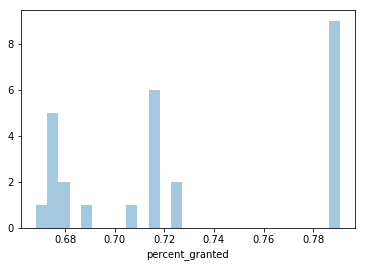

In [221]:
sns.distplot(results.percent_granted, bins=len(results), kde=False)

In [223]:
results["group_size"] = results.campers / results.number_groups
results

,campers,number_groups,ave_requests,percent_granted,group_size
0,100.0,4.0,1.0,0.790909,25.000000
1,100.0,4.0,2.0,0.790909,25.000000
2,100.0,4.0,3.0,0.790909,25.000000
3,100.0,5.0,1.0,0.722727,20.000000
4,100.0,5.0,2.0,0.722727,20.000000
5,100.0,5.0,3.0,0.713636,20.000000
6,100.0,6.0,1.0,0.681818,16.666667
7,100.0,6.0,2.0,0.672727,16.666667
8,100.0,6.0,3.0,0.686364,16.666667
9,200.0,4.0,1.0,0.790909,50.000000
